**Grupo 2:**
- Esteban Daniel Pereira Nuñez
- Maria Bernarda Serrano Larrea
- Damaris Raquel Terrazas Teran
- Oscar Enrique Ibañez Siñani

**TRABAJO REDES NEURONALES, Asignatura: Mineria de datos**

Librerias a instalar:
- pip install Pillow
- pip install scikit-image
- pip install scikit-learn
- pip install pybrain
- pip install structure

Usar PyBrain de Github https://github.com/pybrain/pybrain

In [1]:
# Drawing basic CAPTCHAs

import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [2]:
#def create_captcha(text, shear=0, size=(100, 24)):
def create_captcha(text, shear=0, size=(100, 30)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    
    font = ImageFont.truetype(r"FiraCode-Regular.otf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    
    image = np.array(im)
    
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

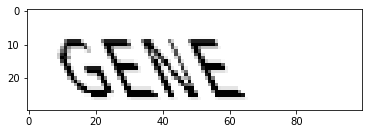

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap='Greys')

In [4]:
# Splitting the image into individual letters

from skimage.measure import label, regionprops

def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

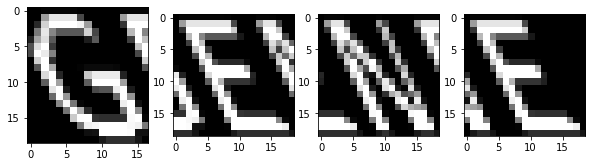

In [5]:
subimages = segment_image(image)

f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [6]:
# Creating a training dataset

from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [7]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)),letters.index(letter)

The target for this image is: 11


c:\program files\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


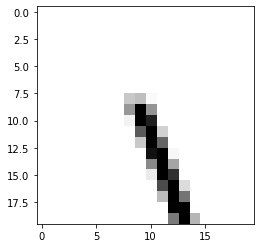

In [8]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")
print("The target for this image is: {0}".format(target))

dataset, targets = zip(*(generate_sample(random_state) for i in
range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

y = y.todense()

In [9]:
# Adjusting our training dataset to our methodology

from skimage.transform import resize
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [10]:
# Training and classifying

from pybrain.datasets import SupervisedDataSet

training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])
    
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])
    
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

In [12]:
# Back propagation

from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01,
weightdecay=0.01)

trainer.trainEpochs(epochs=20)

predictions = trainer.testOnClassData(dataset=testing)

from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1),average='macro' )))

F-score: 0.86


c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [13]:
# Predicting words

def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [14]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, net))

ANNN


In [15]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [18]:
from nltk.corpus import words
valid_words = [word.upper() for word in words.words() if len(word) == 4]

num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = test_prediction(word, net, shear=0.2)
if correct:
    num_correct += 1
else:
    num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 0
Number incorrect is 1


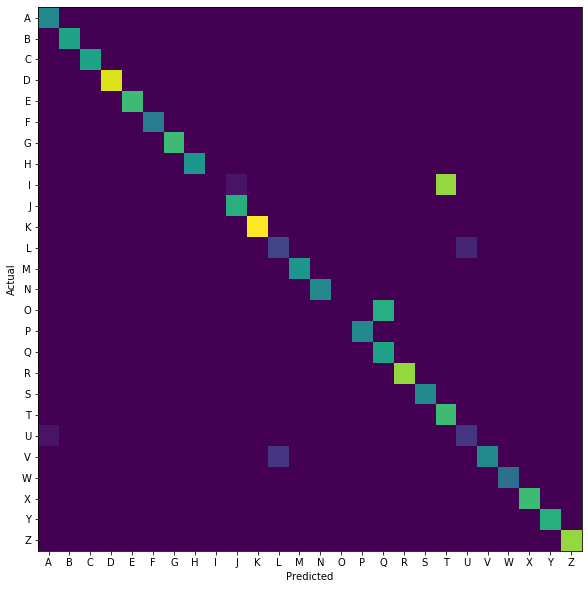

In [19]:
# Ranking mechanisms for words

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plt.figure(figsize=(10, 10))
plt.imshow(cm)

tick_marks = np.arange(len(letters))
plt.xticks(tick_marks, letters)
plt.yticks(tick_marks, letters)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [21]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))

In [22]:
# Putting it all together

from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    
    return word == prediction, word, prediction

In [23]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = improved_prediction(word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 220
Number incorrect is 5293
